In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from itertools import product

In [2]:
from TA_class import TAcalculator, ma_strategy 
%load_ext autoreload
%autoreload 2

In [3]:
stock_code = 'AAPL'
start_date = '2015-01-01'
end_date = '2022-01-01'
column_used = 'Adj Close'
sma1 = [*range(10, 201, 10)]
sma2 = [*range(10, 201, 10)]

In [ ]:
class TAcalculator:

    def __init__(self, stock_code: str, start_date: str, end_date: str, column_used: str='Adj Closed'):
        self.stock_code = stock_code
        self.data: pd.DataFrame = yf.download(stock_code, start=start_date, end=end_date, interval='1d')
        self.colname = column_used
        self.strategies: dict = dict()
        self.backtest_details: dict = dict()
        self._backtest_results: dict = dict()
        self.flag_colname = 'Flag'

    @property
    def backtest_results(self):
        return pd.DataFrame(self._backtest_results).T

    def add_strategy(self, strategy_function, *args, **kwargs):
        name, signals = strategy_function(self.data[self.colname], *args, **kwargs)
        valid_signals = self.validate_strategy(signals)
        self.strategies.update({name: valid_signals})

    def backtest_strategies(self):
        # TODO discrete stock number
        for k, v in self.strategies.items():
            temp = self.data.join(v, how='right')
            df_bull = temp[temp[self.flag_colname] == 1].reset_index()
            df_bear = temp[temp[self.flag_colname] == -1].reset_index()

            srs_pct = df_bear[self.colname] / df_bull[self.colname]
            srs_PnL = df_bear[self.colname] - df_bull[self.colname]
            srs_Cap = df_bull[self.colname] - df_bear[self.colname].shift(1).fillna(0)
            
            df_conc = pd.concat({'Bull': df_bull, 'Bear': df_bear},  axis=1)
            df_conc = df_conc.loc[:, (slice(None), ['Date', self.colname, self.flag_colname])]
            df_conc.columns = ['_'.join(e) for e in df_conc.columns.to_flat_index()]

            dict_srs = {'Multiplier': srs_pct, 'PayinCapital': srs_Cap, 'Profit&Loss': srs_PnL}
            df_conc = df_conc.assign(**dict_srs)
            self.backtest_details[k] = df_conc

            dict_val = {'NumOfCycle': df_conc.shape[0], 'Payin_Capital': srs_Cap.sum(), 'Profit_Loss': srs_PnL.sum()}
            dict_val['Result_Asset'] = dict_val['Payin_Capital'] + dict_val['Profit_Loss']
            dict_val['ReturnOnCap'] = dict_val['Result_Asset'] / dict_val['Payin_Capital']
            dict_val['%_Change'] = (srs_pct.product() - 1) * 100
            self._backtest_results[k] = {k: round(v, 4) for k, v in dict_val.items()}

    def validate_strategy(self, strategy):
        if not self.validate_flags_index(strategy):
            strategy = self.ensure_flags_index(strategy)
        if not self.validate_first_bull(strategy):
            strategy = self.ensure_first_bull(strategy)
        if not self.validate_last_bear(strategy):
            strategy = self.ensure_last_bear(strategy)
        return strategy

    def validate_flags_index(self, strategy, verbose=False):
        # strategy must align with data index
        stra_idx = set(strategy.index)
        data_idx = set(self.data.index)
        diff = stra_idx.symmetric_difference(data_idx)
        if len(diff) == 0:
            return True
        elif verbose:
            print(f'Strategy date is not aligned with trading date\n')

    def ensure_flags_index(self, strategy):
        # align index with
        strategy = strategy.copy()
        strategy = strategy.reindex(self.data.index).fillna(0)
        return strategy
    
    def validate_first_bull(self, strategy, verbose=False):
        # strategy must start with 1 "bull', or the first -1 is skipped
        flags = strategy[strategy != 0]
        if flags.iat[0] == 1:
            return True
        elif verbose:
            print(f'First flag is not bull: {flags.index[0]}\n')
        # strategy[flags.loc[0].index] = 0

    def ensure_first_bull(self, strategy):
        strategy = strategy.copy()
        loc = strategy[strategy != 0].index[0]
        strategy.at[loc] = 0
        return strategy

    def validate_last_bear(self, strategy, verbose=False):
        # strategy must end with -1 "bear:, -1 is assigned at the last date
        flags = strategy[strategy != 0]
        if flags.iat[-1] == -1:
            return True
        elif verbose:
            print(f'Last flag is not bear: {flags.index[-1]}\n')

    def ensure_last_bear(self, strategy):
        strategy = strategy.copy()
        strategy.iat[-1] = -1
        return strategy

    def plot_strategy(self, strategy_name):
        pass
        # Plot moving average with signals and position
        plt.figure(figsize=(20, 10))
        # plot close price, short-term and long-term moving averages
        self.data[self.colname].plot(color='k', label=self.colname)
        # plot 'buy' signals
        flags = self.strategies[strategy_name]
        bull_flags = self.data[self.colname].reindex(flags[flags == 1].index)
        plt.plot(bull_flags.index, bull_flags, '^', markersize=15, color='g', label='buy')
        # plot 'sell' signals
        bear_flags = self.data[self.colname].reindex(flags[flags == -1].index)
        plt.plot(bear_flags.index, bear_flags, 'v', markersize=15, color='r', label='sell')
        plt.ylabel('Price', fontsize=15)
        plt.xlabel('Date', fontsize=15)
        plt.title(self.stock_code + ' at ' + strategy_name, fontsize=20)
        plt.legend()
        plt.grid()
        plt.show()

In [ ]:
def ma_strategy(series: pd.Series, short_period: int, long_period: int) -> dict:
    strategy_name = 'sma' + str(short_period).rjust(3, '0') + '>sma' + str(long_period).rjust(3, '0')
    srs_short = series.rolling(window=short_period, min_periods=short_period).mean()
    srs_long = series.rolling(window=long_period, min_periods=long_period).mean()
    diff = np.sign(srs_short - srs_long)
    signal = diff.diff() / 2
    signal.name = 'Flag'
    # all = pd.concat([srs_short, srs_long, diff, signal], axis=1)
    return strategy_name, signal

In [4]:
objTAC = TAcalculator(stock_code, start_date=start_date, end_date=end_date, column_used=column_used)

[*********************100%***********************]  1 of 1 completed


In [5]:
sma_periods = [(x, y) for x, y in product(sma1, sma2) if x < y]
for short, long in sma_periods:
    objTAC.add_strategy(ma_strategy, short, long)

In [6]:
objTAC.backtest_strategies()

In [7]:
df_BT = objTAC.backtest_results

In [8]:
df_BT = df_BT[(df_BT['%_Change'] > 0) & (df_BT['NumOfCycle'] > 2)]
df_Sort = df_BT.sort_values(['%_Change', 'NumOfCycle'], ascending=False)
df_Sort.head(10)

,NumOfCycle,Payin_Capital,Profit_Loss,Result_Asset,ReturnOnCap,%_Change
sma030>sma200,3.0,34.5998,142.9702,177.57,5.1321,468.6255
sma030>sma180,3.0,36.5990,140.9711,177.57,4.8518,465.9982
sma010>sma200,5.0,36.2119,141.3582,177.57,4.9036,452.9519
sma030>sma170,4.0,34.9873,142.5827,177.57,5.0753,444.8425
sma010>sma190,5.0,39.0324,138.5376,177.57,4.5493,436.7664
sma040>sma170,3.0,43.4892,134.0808,177.57,4.0831,401.4292
sma020>sma200,4.0,43.0528,134.5172,177.57,4.1245,399.9525
sma040>sma160,3.0,45.7319,131.8381,177.57,3.8828,391.9284
sma030>sma160,5.0,51.8171,125.7529,177.57,3.4269,361.1002
sma010>sma180,6.0,50.8340,126.7360,177.57,3.4931,335.2302


sma030>sma200


,Bull_Date,Bull_Adj Close,Bull_Flag,Bear_Date,Bear_Adj Close,Bear_Flag,Multiplier,PayinCapital,Profit&Loss
0,2016-08-17,25.570421,1.0,2018-12-07,40.891575,-1.0,1.599175,25.570421,15.321154
1,2019-04-17,49.509941,1.0,2019-06-17,47.439812,-1.0,0.958188,8.618366,-2.070129
2,2019-06-25,47.850864,1.0,2021-12-31,177.570007,-1.0,3.710905,0.411053,129.719143


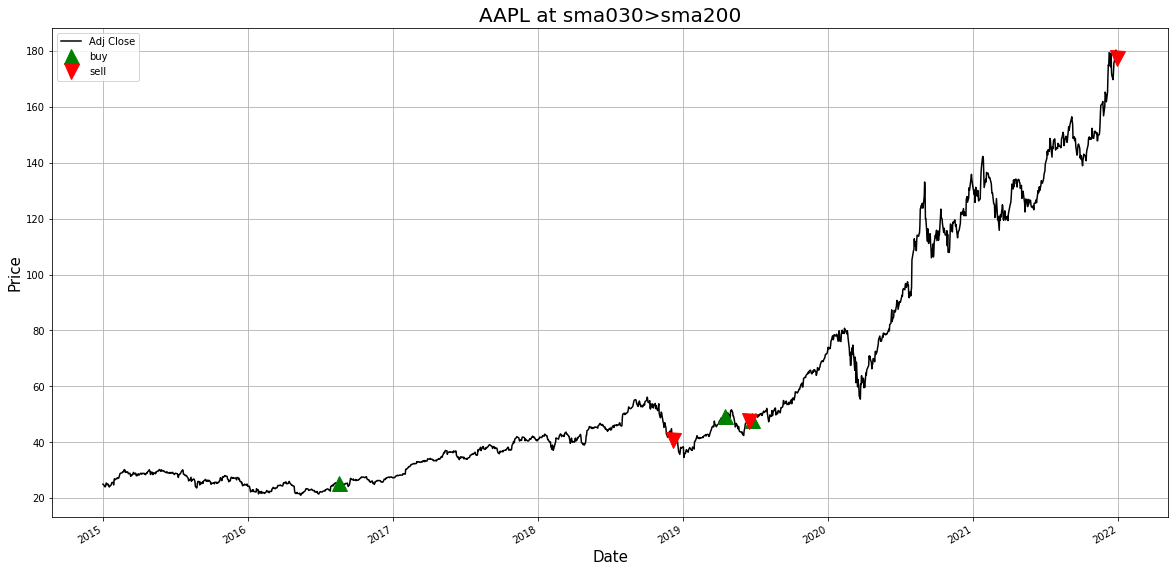

In [10]:
for e in df_Sort.iloc[0:1, :].index:
    print(e)
    display(objTAC.backtest_details[e])
    objTAC.plot_strategy(e)